# Cryptography Project
by Eitan and Juan

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
import random
from datetime import datetime
from itertools import combinations
import string
import pandas
from collections import Counter

## Introduction

Our goal is to decypher a secret message. First let's read in the secret message to see what we are dealing with

In [2]:
with open ("data/encyrption.txt", "r") as myfile:
    message=myfile.read().replace('\n', '')

pp.pprint(message)

'BIU V DICT ZMEF VBZFU MZ NVJ OJGFUFL MCZI ZGMJ NIUDL IB JIUUIN VCL ZUIOQDF QK ZGF HVUMJG JOUTFIC MZ UFEVMCFL V EVZZFU IB PICJMLFUVQDF LIOQZ NGFZGFU ZGF PGMDL NIODL JOURMRF ZI QFVU VCK CVEF VZ VDD MC NGMPG PVJF MZ MJ JIEFNGVZ EIUF ZGVC HUIQVQDF ZGVZ ZGFJF EFEIMUJ NIODL CFRFU GVRF VHHFVUFL IU MB ZGFK GVL ZGVZ QFMCT PIEHUMJFL NMZGMC V PIOHDF IB HVTFJ ZGFK NIODL GVRF HIJJFJJFL ZGF MCFJZMEVQDF EFUMZ IB QFMCT ZGF EIJZ PICPMJF VCL BVMZGBOD JHFPMEFC IB QMITUVHGK FYZVCZ MC ZGF DMZFUVZOUF IB VCK VTF IU PIOCZUK '


This secret message was created using a substitution cipher where each letter maps uniquely to another letter in the alphebet (A $\rightarrow$ L, B $\rightarrow$ R, etc). To break the code we are going to need to find the correct maping $f$ that reveals the secret. 

$$
f : \{`A`,  `B`, \dots, `Z`, ` `\} \rightarrow \{`O`,  `F`, \dots, `J`, ` `\}
$$
Note that for our project we will only be working with capital letters, space will always map to space and there is no puncuation to worry about. 

First we will need a function to generate such a maping

In [3]:
def get_map():
    alphabet = string.uppercase
    key = ''.join(random.sample(alphabet,len(alphabet)))
    myMap = dict(zip(alphabet, key))
    myMap[' '] = ' '
    return myMap

The `dict` data structure seemed like a good way to store these mappings. Lets generate a random mapping to take a look at how `get_map` works

In [4]:
myMap = get_map()
pp.pprint(myMap)

{' ': ' ',
 'A': 'M',
 'B': 'I',
 'C': 'H',
 'D': 'G',
 'E': 'W',
 'F': 'R',
 'G': 'D',
 'H': 'P',
 'I': 'K',
 'J': 'F',
 'K': 'E',
 'L': 'O',
 'M': 'Y',
 'N': 'N',
 'O': 'U',
 'P': 'A',
 'Q': 'L',
 'R': 'Z',
 'S': 'V',
 'T': 'T',
 'U': 'Q',
 'V': 'X',
 'W': 'B',
 'X': 'J',
 'Y': 'S',
 'Z': 'C'}


Now that we having mapping, $f$, we need a way to apply that mapping to encrypt or dycrypt some text.

In [5]:
def encrypt(s, myMap):
    return ''.join([myMap[c] for c in list(s)])

The `encrypt` function takes a string `s` and applies the mapping `mymap` and returns the encrypted string. Lets give our new mapping a try with a test string.

In [6]:
test = 'THIS IS A SUPER SECRET MESSAGE'
secret = encrypt(test,myMap)
print secret

TPKV KV M VQAWZ VWHZWT YWVVMDW


Note that the way `encrypt` as been defined it is not reversable but a `decrypt` function could be implemented

In [7]:
def decrypt(s, myMap):
    inv_map = {v: k for k, v in myMap.items()}
    return ''.join([inv_map[c] for c in list(s)])

By applying the inverted mapping to the encrypted secret we should recover the origial message

In [8]:
anothertest = decrypt(secret, myMap)
print anothertest

THIS IS A SUPER SECRET MESSAGE


## Methods

To crack this code we are going to utilize a matrix $M_{ij}$ that represents the transition frequency from the $i^{th}$ letter of the alphabet to the $j^{th}$. This matrix was calculated using "War and Peace", "Oliver Twist", and
"King James Bible" from Project Gutenberg and was provided for the assignment. Now we will read in the pair frequence matrix for the 26 letters of the alphebet and also the space character

In [9]:
pairFreq = np.loadtxt('data/pairFreq.dat')
pairFreq.shape

(27, 27)

Our strategy for decyphering the text differs from the instructions but will be outlined below. We chose to approach this problem from an optimization perspective rather than a sampling one. Instead of exploring a representative distribution of "likelyhood" probabilities outline in the instructions, our method will quickly converge on the most likely outcome by maximizing a rank function outlined below.

We rank a string as being english if the sum of the $M_{ij}$ is maximized
$$
R(f) = \sum M(f(s_i))(f(s_{i+1}))
$$
where $s_i$ is the $i^{th}$ letter of the encrypted message. This approach was chosen to avoid the effects of logging the zero elements in the frequency matrix. Using an additive rank avoids this problem but will be behave differently than the multiplicative ranking outlined in the instructions. We define our rank fucntion as such

In [10]:
def rate_string(M, s):
    lookup = string.uppercase + ' '
    return np.sum(M[lookup.find(s[i])][lookup.find(s[i+1])] for i in range(len(s) - 1))

where `M` is the pairwise frequency matrix and `s` is a string to be ranked. Our strategy will be to rake the current string, then apply our mapping to generate a new string, and test to see if our new string had a better ranking. If our mapping doesn't increase the rank then we will swap two of the letters in our mapping and again test to see if this new mapping provides a better ranked string. If the rank is better than the new mapping is kept and the process is repeated. The last function needed to attempt this algorithm is one to perform these swaps

In [11]:
def key_swap(myMap, swap_pick):
    swapMap = dict(myMap)
    swapMap[swap_pick[0]] = myMap[swap_pick[1]]
    swapMap[swap_pick[1]] = myMap[swap_pick[0]]
    return swapMap

Here `myMap` is the mapping and `swap_pick` is a randomly generated string of the letters you want to swap. Now all that is left is to write a driver function to perform the optimization

In [12]:
def MC_decrypt(oldS, M, myMap, nsteps = 1000):
    
    allSwaps = [''.join(i) for i in combinations(string.uppercase, 2)]
    p = rate_string(pairFreq, oldS)
    newp = 0.0
    oldmap = dict(myMap)
    t = 0
    t0 = datetime.now()
    for i in range(nsteps):
        mySwap = allSwaps[random.randint(0,len(allSwaps)-1)]
        newmap = dict(key_swap(oldmap, mySwap))
        newS = encrypt(oldS, newmap)
        newp = rate_string(pairFreq, newS)
        if(p < newp):
            oldmap = dict(newmap)
            p = newp
            t += 1

    t1 = datetime.now()
    tdiff = t1-t0

    #print "Total run time: " + str(tdiff)[2:10] + "s"
    #print "p = " + str(p)
    #print "Acceptance Ratio = " + str(100*float(t)/float(nsteps)) + '%'
    return encrypt(oldS, oldmap)

It's important to note here that we always accept the change if it increases our rank. This is known as "simulated quenching" and is useful for a local optimization but might get stuck, not finding the global maxima. 

## Results
Lets run our simulation to see what we get

In [13]:
MC_decrypt(message, pairFreq, myMap)

'FIN A LIHG OTME AFOEN TO WAS CSRENED THOI ORTS WINLD IF SINNIW AHD ONICBLE BY ORE UANTSR SCNGEIH TO NEMATHED A MAOOEN IF PIHSTDENABLE DICBO WREOREN ORE PRTLD WICLD SCNVTVE OI BEAN AHY HAME AO ALL TH WRTPR PASE TO TS SIMEWRAO MINE ORAH UNIBABLE ORAO ORESE MEMITNS WICLD HEVEN RAVE AUUEANED IN TF OREY RAD ORAO BETHG PIMUNTSED WTORTH A PICULE IF UAGES OREY WICLD RAVE UISSESSED ORE THESOTMABLE MENTO IF BETHG ORE MISO PIHPTSE AHD FATORFCL SUEPTMEH IF BTIGNAURY EXOAHO TH ORE LTOENAOCNE IF AHY AGE IN PICHONY '

If we run the same simulation again using the same intial conditions we might get different results do to the effects of simulated quneching. 

In [14]:
MC_decrypt(message, pairFreq, myMap)

'FOR A LONV TCHE AFTER CT WAS USIERED CNTO TICS WORLD OF SORROW AND TROUMLE MG TIE PARCSI SURVEON CT REHACNED A HATTER OF BONSCDERAMLE DOUMT WIETIER TIE BICLD WOULD SURYCYE TO MEAR ANG NAHE AT ALL CN WICBI BASE CT CS SOHEWIAT HORE TIAN PROMAMLE TIAT TIESE HEHOCRS WOULD NEYER IAYE APPEARED OR CF TIEG IAD TIAT MECNV BOHPRCSED WCTICN A BOUPLE OF PAVES TIEG WOULD IAYE POSSESSED TIE CNESTCHAMLE HERCT OF MECNV TIE HOST BONBCSE AND FACTIFUL SPEBCHEN OF MCOVRAPIG EXTANT CN TIE LCTERATURE OF ANG AVE OR BOUNTRG '

We could try to increas the number of steps but we will just remain stuck in the local minima. A way to remedy this problem is to run the decryption multiple times and see if there is a most common output

In [15]:
multi_run = np.array([list(MC_decrypt(message, pairFreq, myMap)) for i in range(20)])

we will need to transpose the output so that each row represents all of the outputs for a given charater of our message

In [16]:
letter_cols = zip(*multi_run)

Now we can find the mode of each charater position to find the final expected output

In [17]:
''.join( c for c in [Counter(letter_cols[x]).most_common(1)[0][0] for x in range(len(letter_cols))])

'FOR A LONG TIME AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUBLE BY THE PARISH SURGEON IT REMAINED A MATTER OF CONSIDERABLE DOUBT WHETHER THE CHILD WOULD SURVIVE TO BEAR ANY NAME AT ALL IN WHICH CASE IT IS SOMEWHAT MORE THAN PROBABLE THAT THESE MEMOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT BEING COMPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIMABLE MERIT OF BEING THE MOST CONCISE AND FAITHFUL SPECIMEN OF BIOGRAPHY EXTANT IN THE LITERATURE OF ANY AGE OR COUNTRY '

It appears that our secret message was a quote from "Oliver Twist". With this method we can avoid relaying on a single decryption that may have been stuck in a local maxima. The
relativly short single decryption time (less than a second) allows for multiple runs to be used to build the most common result.

## Sampling Approach

In [18]:
newM = pairFreq + 1e-30

In [19]:
def log_rate_string(M, s):
    lookup = string.uppercase + ' '
    return np.sum(np.log(M[lookup.find(s[i])][lookup.find(s[i+1])]) for i in range(len(s) - 1))

In [20]:
def samp_MC_decrypt(oldS, M, myMap, nsteps = 3000):
    
    allSwaps = [''.join(i) for i in combinations(string.uppercase, 2)]
    p = log_rate_string(M, oldS)
    newp = 0.0001
    oldmap = dict(myMap)
    t = 0
    t0 = datetime.now()
    recP = []
    recPstr = []
    for i in range(nsteps):
        mySwap = allSwaps[random.randint(0,len(allSwaps)-1)]
        newmap = dict(key_swap(oldmap, mySwap))
        newS = encrypt(oldS, newmap)
        newp = log_rate_string(M, newS)
        ratio  = newp - p
        recP.append(p)
        if(np.exp(ratio) > np.random.rand()):
            oldmap = dict(newmap)
            p = newp
            t += 1

    t1 = datetime.now()
    tdiff = t1-t0

    print "Total run time: " + str(tdiff)[2:10] + "s"
    print "p = " + str(p)
    print "Acceptance Ratio = " + str(100*float(t)/float(nsteps)) + '%'
    return recP, encrypt(oldS, oldmap)

In [21]:
recP, results = samp_MC_decrypt(message, newM, myMap)
print results

Total run time: 00:04.37s
p = 5443.28545499
Acceptance Ratio = 3.9%
FOR A LONG TIME AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUBLE BY THE PARISH SURGEON IT REMAINED A MATTER OF CONSIDERABLE DOUBT WHETHER THE CHILD WOULD SURVIVE TO BEAR ANY NAME AT ALL IN WHICH CASE IT IS SOMEWHAT MORE THAN PROBABLE THAT THESE MEMOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT BEING COMPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIMABLE MERIT OF BEING THE MOST CONCISE AND FAITHFUL SPECIMEN OF BIOGRAPHY EXTANT IN THE LITERATURE OF ANY AGE OR COUNTRY 


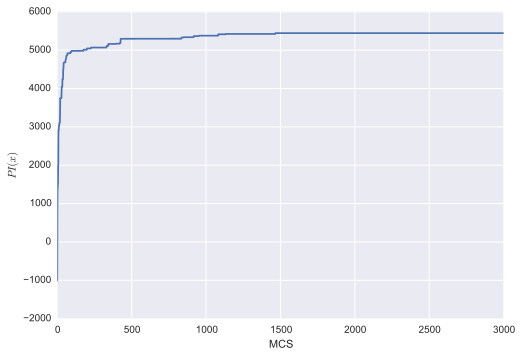

In [22]:
plt.plot(range(3000), recP)
plt.xlabel('MCS')
plt.ylabel(r'$PI(x)$')

In [23]:
[x - recP[i - 1] for i, x in enumerate(recP) if x - recP[i - 1] < 0.0]

[-6451.5767326455943,
 -0.37260035623512522,
 -0.078398520594419097,
 -0.078398520594419097,
 -1.9051428778766422]

## A New Message

One test was to give the fucntions a different message and see if it could crack the code

In [24]:
moreSecrets = ('A FAKE SENTENCE TO TRY AND TEST OUT THE CODE ABOVE AND SEE HOW WELL IT PERFORMS ' +
               'WITH A DIFFERENT INPUT BUT ALSO MAKING SURE THAT IT LONG ENOUGH THAT WE CAN GET ' +
               'RESONABLE RESULTS IN A SHORT AMOUNT OF TIME')
another_map = get_map()
codedSecret = encrypt(moreSecrets, another_map)
codedSecret

'H QHGS TSXRSXIS RC RAV HXE RSTR CMR RNS ICES HWCPS HXE TSS NCD DSLL OR BSAQCAZT DORN H EOQQSASXR OXBMR WMR HLTC ZHGOXJ TMAS RNHR OR LCXJ SXCMJN RNHR DS IHX JSR ASTCXHWLS ASTMLRT OX H TNCAR HZCMXR CQ ROZS'

In [25]:
recP, results = samp_MC_decrypt(codedSecret, newM, myMap)
print results

Total run time: 00:01.79s
p = 2178.15424977
Acceptance Ratio = 4.86666666667%
A FAVE SENTENCE TO TRY AND TEST OUT THE CODE APOKE AND SEE HOW WELL IT BERFORMS WITH A DIFFERENT INBUT PUT ALSO MAVING SURE THAT IT LONG ENOUGH THAT WE CAN GET RESONAPLE RESULTS IN A SHORT AMOUNT OF TIME


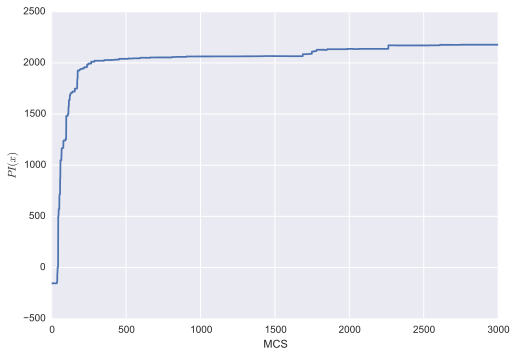

In [26]:
plt.plot(range(len(recP)), recP)
plt.xlabel('MCS')
plt.ylabel(r'$PI(x)$')

## Improvements

One technique which was not explored would be to look at the single letter frequency in our inital message to pick a better inital mapping rather than just starting with a random mapping

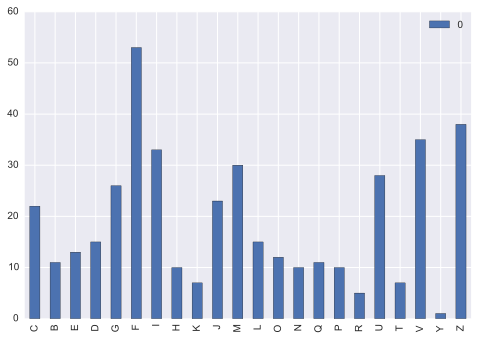

In [27]:
nospaces = ''.join([x for x in message.split()])
letter_counts = Counter(sorted(nospaces))
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

Matching this histogram with one of known frequencies could lead to a good place to start. 